In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [21]:
layer_num=3
hidden_num=64

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)+self.MLP(-x)

In [22]:
def potential(x):
    poten=x*torch.sin(torch.pi*x/2.5)*10+x**4/25
    return poten

In [23]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La=-10
Lb =10
L=Lb-La  # domain length
N = 3000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=100
extend_num=0
epoch=300000
lr=0.01
# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


In [24]:
# 计算初始的本征值
V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

print('initial eigenvalues check:')
print(eigenvalues[:en_num])
real_po=eigenvalues[:en_num]

initial eigenvalues check:
tensor([-25.5775, -25.5774, -17.6892, -17.6891, -10.1361, -10.1360,  -2.9692,
         -2.9690,   2.4016,   3.7313,   3.7327,   6.9734,   9.7985,   9.7991,
         11.0023,  13.9661,  14.7494,  15.3219,  17.2688,  18.9108,  20.4834,
         22.3310,  24.2866,  26.3091,  28.4237,  30.6195,  32.8902,  35.2292,
         37.6341,  40.1018,  42.6298,  45.2116,  47.8474,  50.5314,  53.2612,
         56.0363,  58.8555,  61.7141,  64.6106,  67.5392,  70.4998,  73.4915,
         76.5129,  79.5604,  82.6284,  85.7135,  88.8172,  91.9364,  95.0663,
         98.2050, 101.3482, 104.4930, 107.6357, 110.7707, 113.8944, 116.9989,
        120.0789, 121.3663, 121.3675, 123.1256, 126.1257, 129.0616, 130.2027,
        130.2029, 131.9168, 134.6121, 136.7947, 137.5042, 138.1086, 139.9327,
        141.8542, 143.4665, 145.0171, 146.7467, 148.6083, 150.5070, 152.4268,
        154.3868, 156.3953, 158.4422, 160.5238, 162.6445, 164.7957, 166.9754,
        169.1907, 171.4347, 173.7072,

In [25]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=50,threshold=1e-4)
loss_fn=nn.MSELoss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    V_diag_real=potential(grid)
    val_loss=loss_fn(V_diag,V_diag_real)
    val_loss.backward()
    optimizer.step()
    
    loss_list.append(val_loss.item())
    
    if i%10==0:
        # clear_output(wait=True)
        print(f'epoch:{i},val_loss:{val_loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    scheduler.step(val_loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
print('terminal epoch: ',i+1)


epoch:0,val_loss:13832.3720703125,time:0.007164716720581055,lr:0.01
epoch:10,val_loss:6383.755859375,time:0.04725170135498047,lr:0.01
epoch:20,val_loss:1934.933837890625,time:0.08981442451477051,lr:0.01
epoch:30,val_loss:1307.345458984375,time:0.12694501876831055,lr:0.01
epoch:40,val_loss:1036.546875,time:0.16427993774414062,lr:0.01
epoch:50,val_loss:921.3455200195312,time:0.2052159309387207,lr:0.01
epoch:60,val_loss:878.8866577148438,time:0.24439716339111328,lr:0.01
epoch:70,val_loss:809.18701171875,time:0.282623291015625,lr:0.01
epoch:80,val_loss:676.47998046875,time:0.31906604766845703,lr:0.01
epoch:90,val_loss:458.75323486328125,time:0.3554685115814209,lr:0.01
epoch:100,val_loss:2183.509521484375,time:0.39303064346313477,lr:0.01
epoch:110,val_loss:718.6713256835938,time:0.43306517601013184,lr:0.01
epoch:120,val_loss:219.17115783691406,time:0.47283005714416504,lr:0.01
epoch:130,val_loss:604.0568237304688,time:0.5109751224517822,lr:0.01
epoch:140,val_loss:303.06988525390625,time:0.54

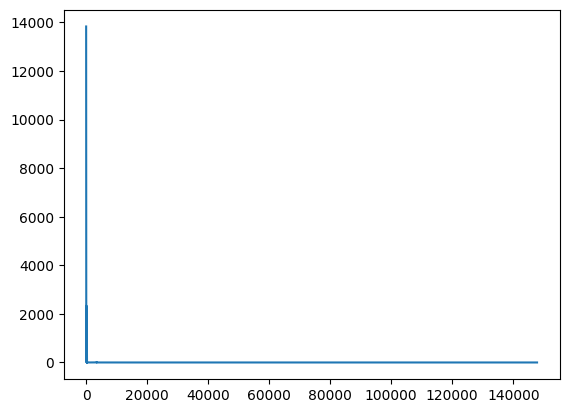

In [26]:
plt.plot(loss_list)
plt.show()

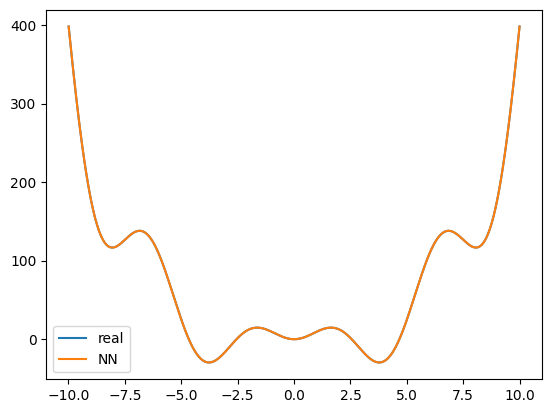

In [27]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid)
real_poten=real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [28]:
#保存模型参数
os.makedirs(f'./model_para_direct', exist_ok=True)
model_path=f'./model_para_direct/model_2_fun2.pth'
torch.save(model.state_dict(), model_path)
# 读取模型参数
# model_2 = Mynetwork().to(device=device,dtype=dtype)
# model_2.load_state_dict(torch.load(model_path))
# model_2.eval()

In [10]:
# os.makedirs(f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
# torch.save(V_NN,f'./V_NN_value_{sym}_{layer_num}_{hidden_num}_{dtype}/V_NN_use_eigvalues_{en_num}_La{La}_Lb{Lb}_N{N}.pth')

In [10]:
error=V_NN-real_poten
mean_error=np.mean(np.abs(error))
max_error=np.max(np.abs(error))
print('mean_error:',mean_error)
print('max_error:',max_error)

mean_error: 0.058842864
max_error: 1.5417786


mean_error: tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)
max_error: tensor(0.0198, device='cuda:0', grad_fn=<MaxBackward1>)


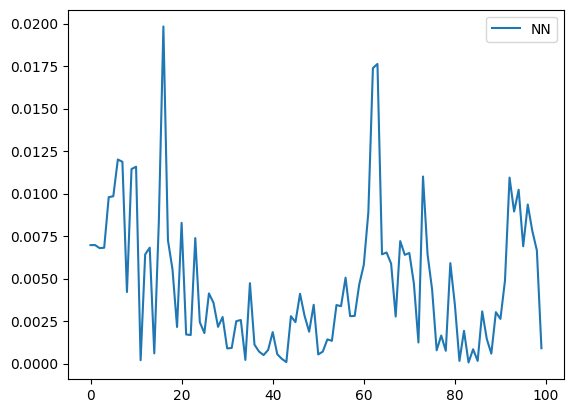

In [11]:
# 计算初始的本征值
en_num=100
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
model_en=eigenvalues[:en_num]

V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
real_en=eigenvalues[:en_num]    
error=torch.abs(model_en-real_en)
print('mean_error:',torch.mean(error))
print('max_error:',torch.max(error))

plt.plot(error.detach().cpu().numpy(),label='NN')
plt.legend()
plt.show()